In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import datetime
import time
import re

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vanik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vanik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vanik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
stopwords = set(stopwords.words('english'))
symbols = ['.', ',', '’','“','”','"', "''" ,"'",'*','``', '**','$','%','&','#','-','--',"''",'""','?', '!', ':', ';', '(', ')', '[', ']', '{', '}', "'s", "'m", "n't", '...']
stopwords.update(symbols)

Reddit論壇，與fund關鍵字相關的討論文章，總共有249筆資料

In [3]:
data = pd.read_csv('keywords_year_fund.csv')

In [4]:
data.shape

(249, 5)

In [5]:
data.tail()

,Date,Name,Score,Title,Content
244,2020-03-04,ChocolateTsar,424,"Robinhood offers $15 discount, blames outage o...",>The $912 million-funded fintech giant will pr...
245,2020-01-20,UKARCADIA,0,Breakdown and allocation of funds,"Hello, is this a good selection of funds / ass..."
246,2019-12-17,EPIC_FAIL_73,6,I wish they made slightly leveraged (10-25%) i...,NaN
247,2019-09-03,tssenek,148,Pension Funds Are Going To Be Destroyed In The...,"I thought about posting the link, but I can un..."
248,2019-12-25,throwaway29u82,5,Has anyone been holding index funds for at lea...,NaN


先針對文章標題提取常出現的關鍵詞

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 5 columns):
Date       249 non-null object
Name       249 non-null object
Score      249 non-null int64
Title      249 non-null object
Content    231 non-null object
dtypes: int64(1), object(4)
memory usage: 9.8+ KB


👆🏻，先看資料的基本資訊，只有content有遺失值，但是因為這次是要針對title做特徵擷取的動作，所以先不處理。

## 斷詞

In [7]:
filtered_title = []
lemmatizer = WordNetLemmatizer()

for title in data['Title']:
    filtered_title.append([lemmatizer.lemmatize(word, pos="n") for word in word_tokenize(title.lower()) if word not in stopwords])

- filtered_title：每筆標題出現的字詞

In [8]:
len(filtered_title)

249

In [9]:
collection = sum(filtered_title, [])
len(collection)

2007

In [10]:
garbage_keyword = []
for i in collection:
    if len(i) < 3:
        garbage_keyword.append(i)
garbage_keyword = list(dict.fromkeys(garbage_keyword))

👆🏻，把每筆資料合併，總共有出現2007個字詞（包含重複）

In [11]:
each_words = nltk.FreqDist(collection)
each_words.values()
EachWords = pd.DataFrame.from_dict(each_words, orient='index', columns=['count'])
EachWords = EachWords.sort_values(by=['count'], ascending=False)
temp = EachWords['count']>5

- 總共有862個單詞

取出出現次數大於5的單詞

In [12]:
temp.value_counts()

False    813
True      48
Name: count, dtype: int64

In [13]:
keywords = EachWords[:49].reset_index()
keywords = keywords.drop([23,24,25,41,44])

統計原始資料的Title中，關鍵字出現的次數，建立稀疏矩陣

In [14]:
def reddit(text, stopword_list):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word.lower(),pos = 'n') for word in word_tokenize(str(text).lower()) if word not in stopword_list]

data['title_embedded'] = data['Title'].apply(lambda text:reddit(text, stopwords))

In [15]:
data_list = data['title_embedded']

def creat_matrix(list_):
    output = []
    for i in list(keywords['index']):
        if i in list_:
            count = 0
            for j in list_:
                if j == i:
                    count += 1
            output.append(count)
            continue
        output.append(0)
    return output

In [16]:
data_list1 = data_list.apply(creat_matrix)
data_matrix = pd.DataFrame(list(data_list1), columns=list(keywords['index']))
data_matrix.head()

,fund,index,mutual,bond,market,advice,question,etf,stock,money,...,high,sell,account,dividend,right,drop,recession,buying,billion,get
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


👆🏻，每個Title出現關鍵字的稀疏矩陣

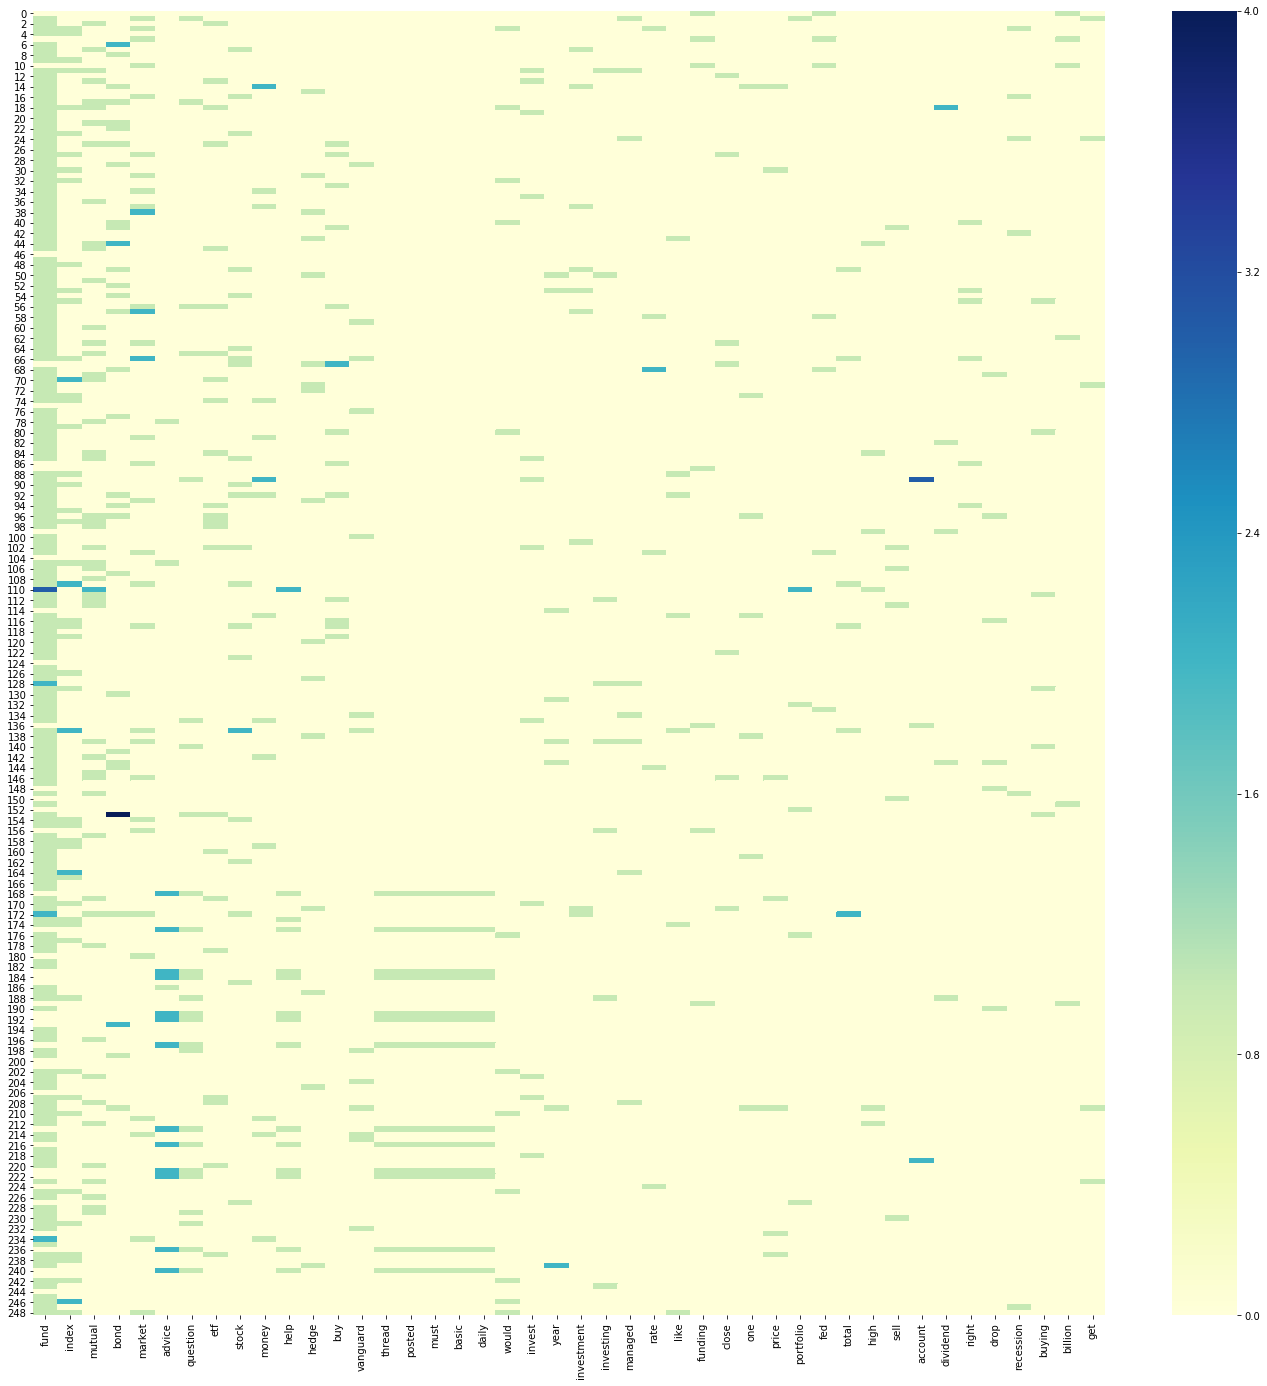

In [17]:
plt.figure(figsize=(24,24))
sns.heatmap(data_matrix, cmap='YlGnBu')
plt.show()

👆🏻，稀疏矩陣的熱力圖

## Co-occurrence Matrix 

建立共現矩陣，並熱力圖看關鍵字之間的關係

In [18]:
data_matrix_T = data_matrix.transpose()
co_matrix = data_matrix_T.dot(data_matrix)
co_matrix.head()

,fund,index,mutual,bond,market,advice,question,etf,stock,money,...,high,sell,account,dividend,right,drop,recession,buying,billion,get
fund,224,55,55,35,31,3,12,23,20,17,...,7,5,5,5,5,5,6,6,2,5
index,55,65,6,0,11,1,2,7,11,2,...,0,0,0,3,3,1,1,2,0,0
mutual,55,6,52,7,4,2,3,15,4,1,...,5,3,0,2,0,2,1,1,0,1
bond,35,0,7,54,3,0,5,7,4,3,...,3,1,0,1,2,2,0,4,0,1
market,31,11,4,3,40,0,2,1,9,6,...,0,0,0,0,3,0,2,0,2,1


In [19]:
co_matrix_norm = np.divide(co_matrix, list(keywords['count']))
co_matrix_norm.head()

,fund,index,mutual,bond,market,advice,question,etf,stock,money,...,high,sell,account,dividend,right,drop,recession,buying,billion,get
fund,1.056604,1.000000,1.10,0.972222,0.911765,0.103448,0.48,1.000000,0.909091,1.0625,...,1.166667,0.833333,0.833333,0.833333,0.833333,0.833333,1.000000,1.000000,0.333333,1.0
index,0.259434,1.181818,0.12,0.000000,0.323529,0.034483,0.08,0.304348,0.500000,0.1250,...,0.000000,0.000000,0.000000,0.500000,0.500000,0.166667,0.166667,0.333333,0.000000,0.0
mutual,0.259434,0.109091,1.04,0.194444,0.117647,0.068966,0.12,0.652174,0.181818,0.0625,...,0.833333,0.500000,0.000000,0.333333,0.000000,0.333333,0.166667,0.166667,0.000000,0.2
bond,0.165094,0.000000,0.14,1.500000,0.088235,0.000000,0.20,0.304348,0.181818,0.1875,...,0.500000,0.166667,0.000000,0.166667,0.333333,0.333333,0.000000,0.666667,0.000000,0.2
market,0.146226,0.200000,0.08,0.083333,1.176471,0.000000,0.08,0.043478,0.409091,0.3750,...,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.333333,0.000000,0.333333,0.2


👆🏻，把資料正則化

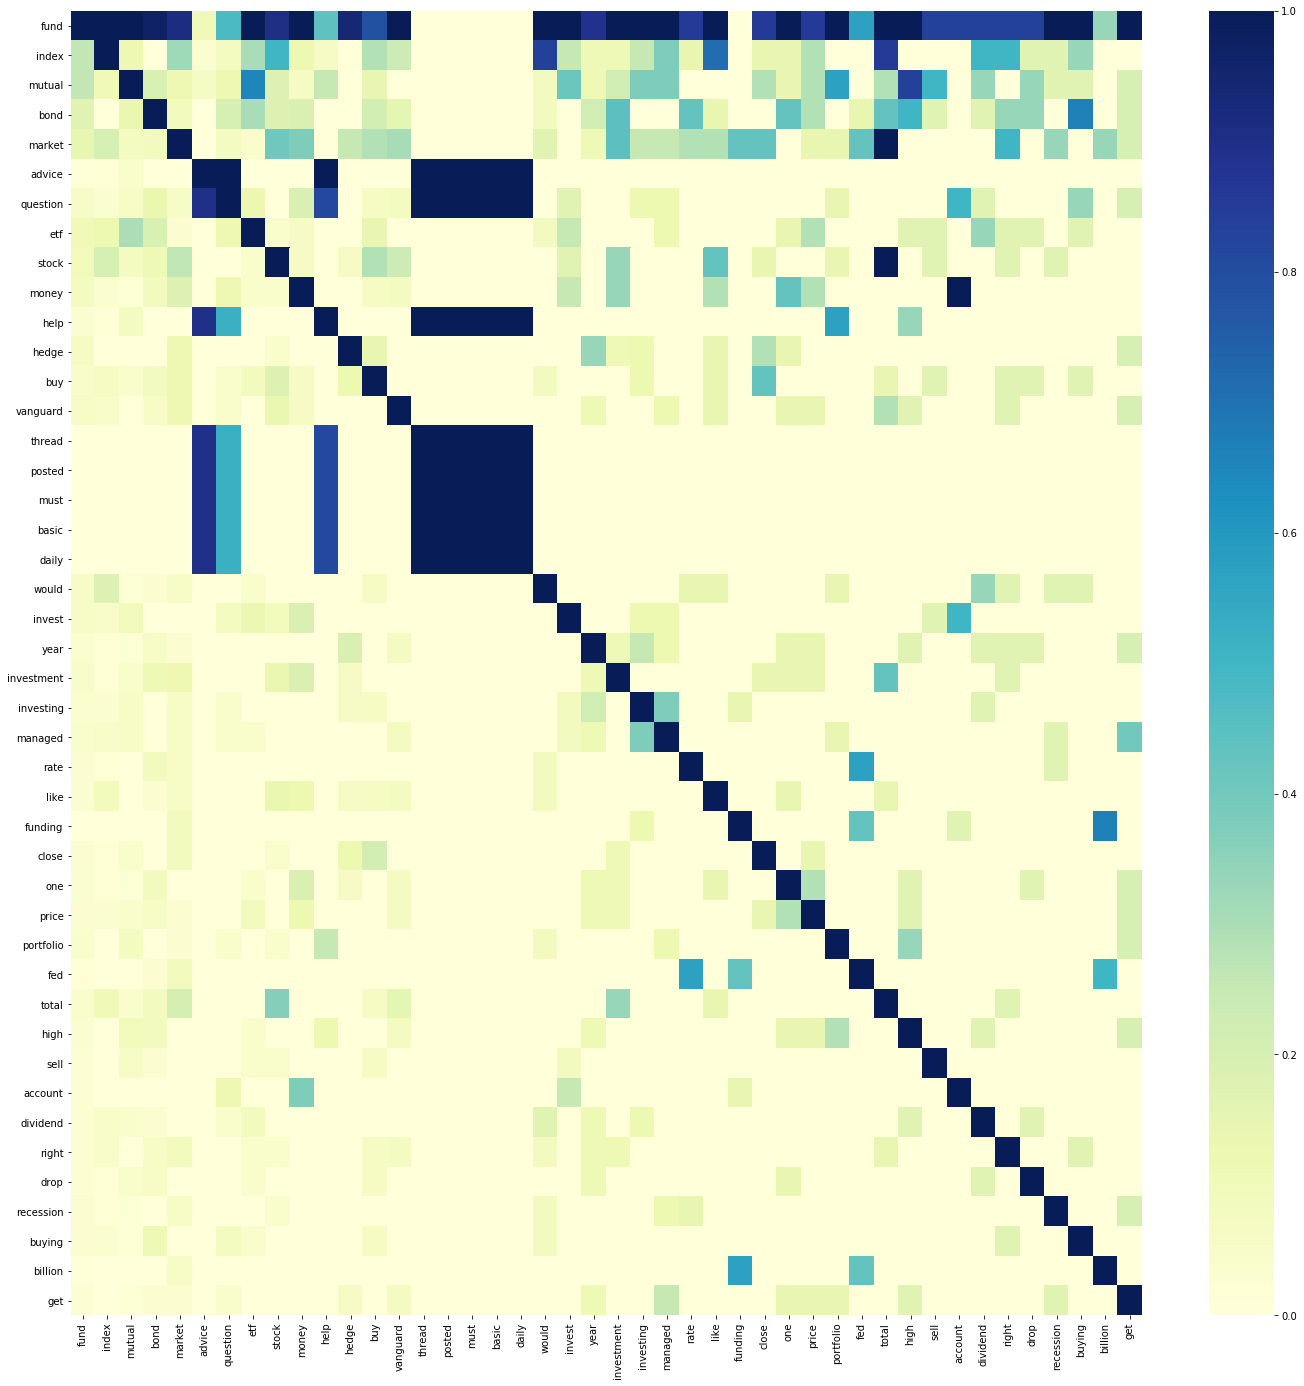

In [20]:
plt.figure(figsize=(24,24))
sns.heatmap(co_matrix_norm, vmin=0, vmax=1, cmap='YlGnBu')
plt.show()

👆🏻，把Co-occurrence Matrix繪製熱力圖

## 繪製network（網絡圖）

In [21]:
corr = []
for col in co_matrix_norm.columns:
    for row in co_matrix_norm.columns:
        if co_matrix_norm[col][row] > 0:
            corr.append((col, row, co_matrix_norm.loc[col][row]))

In [22]:
graph = nx.Graph()
graph.add_weighted_edges_from(corr)

C:\Users\vanik\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\vanik\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


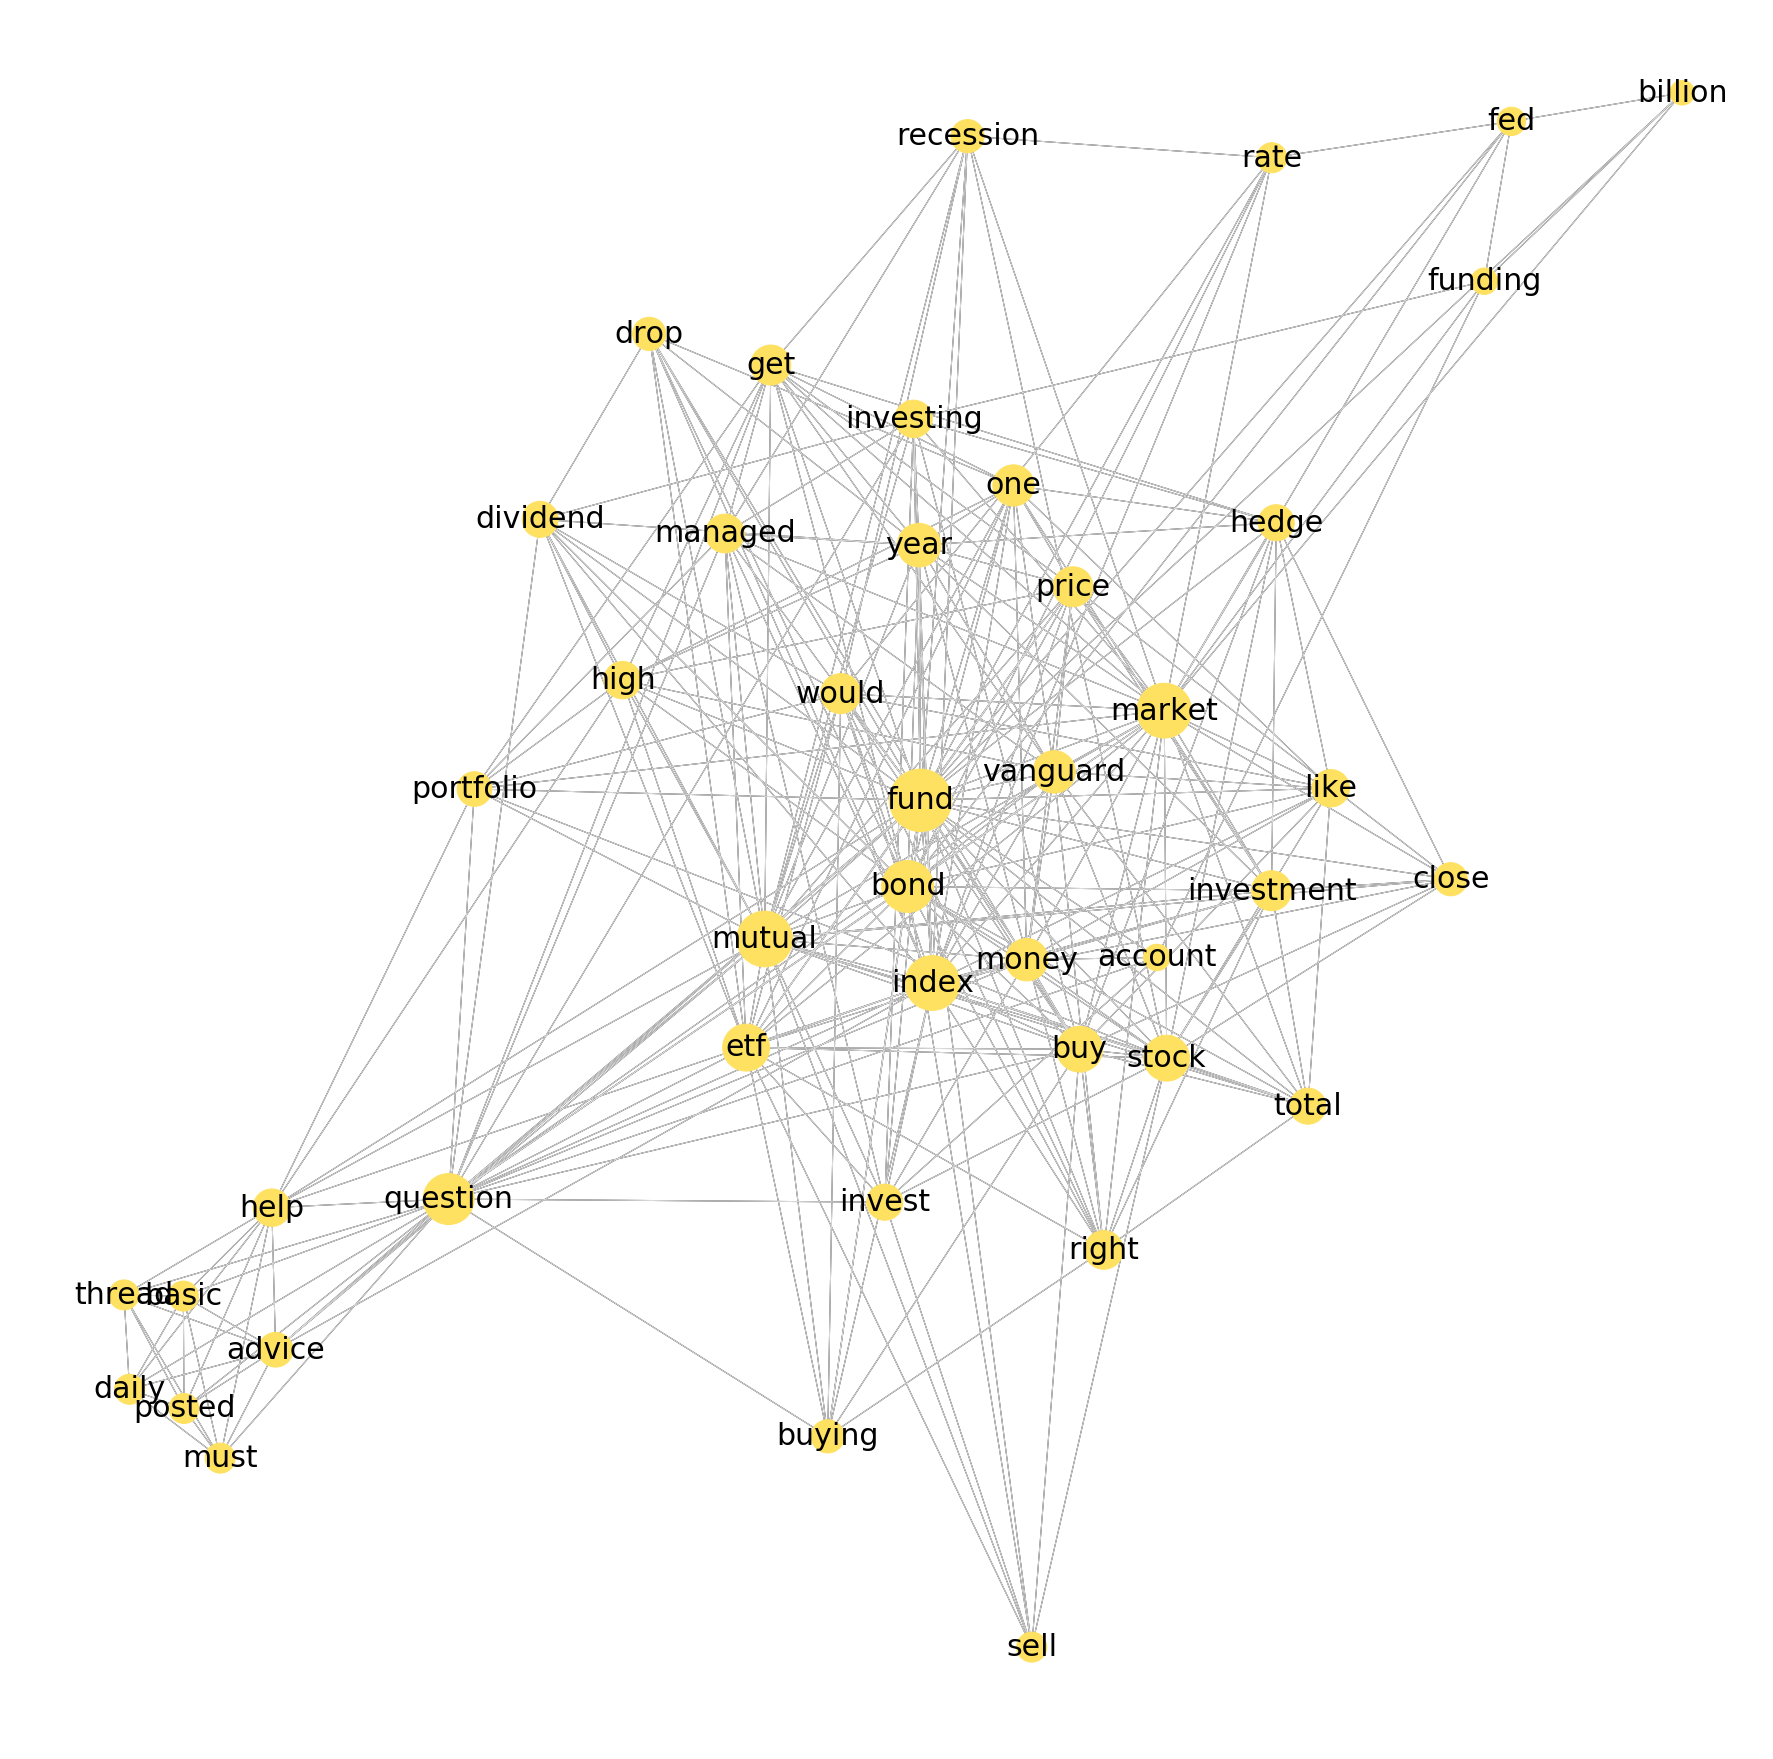

In [23]:
plt.figure(figsize=(24,24))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_size = [val*100 for (node, val) in graph.degree()],node_color = '#FFE162')
nx.draw_networkx_labels(graph, pos, font_size = 30,alpha = 1)
nx.draw_networkx_edges(graph, pos, edge_color = '#DDDDDD', alpha = 1)
# plt.show()